#### NOTE ABOUT THE PSD CALCULATIONS
Throwing away steps 4, 5 from each optic because they have a strange defocus component.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
np.set_printoptions(suppress=True) # scientific notation gets annoying
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import zernike as zern
from model_kit import dust
import poppy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 20/09/2021 13:10:59


In [2]:
# initialize the data
tot_fm = 8
tot_step= 4 # the last 2 step sets are bad news 
fits_folder = 'flat_mirrors/fixed_fits/'
raw_folder = 'flat_mirrors/2018_03_23/'

opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.05*u.m, #50*u.mm,
             'label': '2in',
             'ring_width': 5,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

for fmn in range(0, tot_fm):
    fm_num = fmn+1
    for ns in range(0, tot_step):
        # call in the file
        fm_loc = raw_folder+'flat_{0}_n{1}_100percent_step{2}.datx'.format(opt_parms['label'],fm_num, ns)
        surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=opt_parms['diam_100CA'])
        wavelen = sp['value'][sp['label'].index('wavelen')] # should be same for all steps
        latres = sp['value'][sp['label'].index('latres')]

        if ns==0 and fmn==0:
            opt_parms['surf_units'] = sp['value'][sp['label'].index('surfunit')]
            opt_parms['wavelen'] = wavelen
            opt_parms['latres'] = latres
        
        # tighten up the matrix by removing empty rows and columns
        surf, mask = dfx.mat_tight(surf, mask)

        # apply a resize
        surf, mask = dfx.reduce_ca(data=surf, mask=mask, old_ca=100, new_ca=opt_parms['ca']) 
        # write data to a matrix
        if ns==0 and fmn==0: # initialize first time
            opt_parms['diam_ca'] = mask.shape[0]*latres.to(u.m/u.pix)
            data_set = np.zeros((tot_fm, tot_step, mask.shape[0], mask.shape[0])) # initialize
        data_set[fmn, ns, :, :] = surf.value

    print('Completed flat mirror n{0} file opening to local environment'.format(fm_num))
            
raw_surf = data_set * surf.unit
raw_mask = mask

Completed flat mirror n1 file opening to local environment
Completed flat mirror n2 file opening to local environment
Completed flat mirror n3 file opening to local environment
Completed flat mirror n4 file opening to local environment
Completed flat mirror n5 file opening to local environment
Completed flat mirror n6 file opening to local environment
Completed flat mirror n7 file opening to local environment
Completed flat mirror n8 file opening to local environment


In [3]:
# create all the dust maps
# center of dust based on n8 flat
dcen_x =([[ 46, 68,   89, 111],# 133, 154],
          [ 71, 93,  114, 136],# 158, 179],
          [ 56, 78,   99, 121],# 143, 164],
          [ 78, 100, 121, 143],# 165, 186],
          [318, 340, 361, 383]])# 405, 426]])
dcen_y= [259, 129, 152, 329, 181]
dust_radius=13 # oversize for everyone, not many pixels to lose

x_offset = [-5, -4, +2, -2,  0, +3, +1, 0]
y_offset = [ 0, -1, -1, -1, -1,  0, -1, 0]

# build dust lists
dust_set = np.zeros_like(data_set)

# Build Zernike listing
zm_cor_ptt = np.zeros_like(data_set)
nt_ptt = 3

# This loop masks the dust per step for all the optics
for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    opt_parms['fm_num'] = nf+1
    
    # build all dust mask
    all_dust = np.ones((tot_step, mask.shape[0], mask.shape[1]))
    
    # analyzing per step
    for ns in range(0, tot_step):
        opt_parms['step_num'] = ns
        mask_step = np.ones_like(mask).astype(float) # initialize step mask
        
        # build each dust location at the step
        for nd in range(0, np.shape(dcen_x)[0]): 
            dmc = np.zeros_like(mask)
            if dcen_x[nd][ns] != 0: # if there is a value, then make a mask. Otherwise, skip.
                dm_coord = draw.circle(r=dcen_y[nd]+y_offset[nf], 
                                       c=dcen_x[nd][ns]+x_offset[nf],
                                       radius=dust_radius)
                dmc[dm_coord] = True
            mask_step[dmc==True] = 0 #np.nan
        all_dust[ns] = mask_step * mask
        
        # for the dust mask made in the optic and step, remove the Zernike of surface.
        zsurf, zprj = dfx.apply_zern_arb(raw_surf = raw_surf[nf][ns], 
                                                dust_mask = all_dust[ns],
                                                nt = nt_ptt,
                                                opt_parms = opt_parms,
                                                write_file = False,
                                                folder_loc=fits_folder)#.value
        zm_cor_ptt[nf][ns] = zsurf.value
        
        
    # Save the dust information
    dust_set[nf] = all_dust
    #print('-------------------')
    print('Dust masked and surface with Z{0} removed for all steps in n{1}'.format(nt_ptt, nf+1))

# apply the units for the zernike surface
zm_cor_ptt = zm_cor_ptt * raw_surf.unit

# remove the terms from the dictionary, only temporary
del opt_parms['fm_num']
del opt_parms['step_num']

Dust masked and surface with Z3 removed for all steps in n1
Dust masked and surface with Z3 removed for all steps in n2
Dust masked and surface with Z3 removed for all steps in n3
Dust masked and surface with Z3 removed for all steps in n4
Dust masked and surface with Z3 removed for all steps in n5
Dust masked and surface with Z3 removed for all steps in n6
Dust masked and surface with Z3 removed for all steps in n7
Dust masked and surface with Z3 removed for all steps in n8


In [7]:
(dust_radius*2*opt_parms['latres']*u.pix).to(u.mm)

<Quantity 2.31729055 mm>

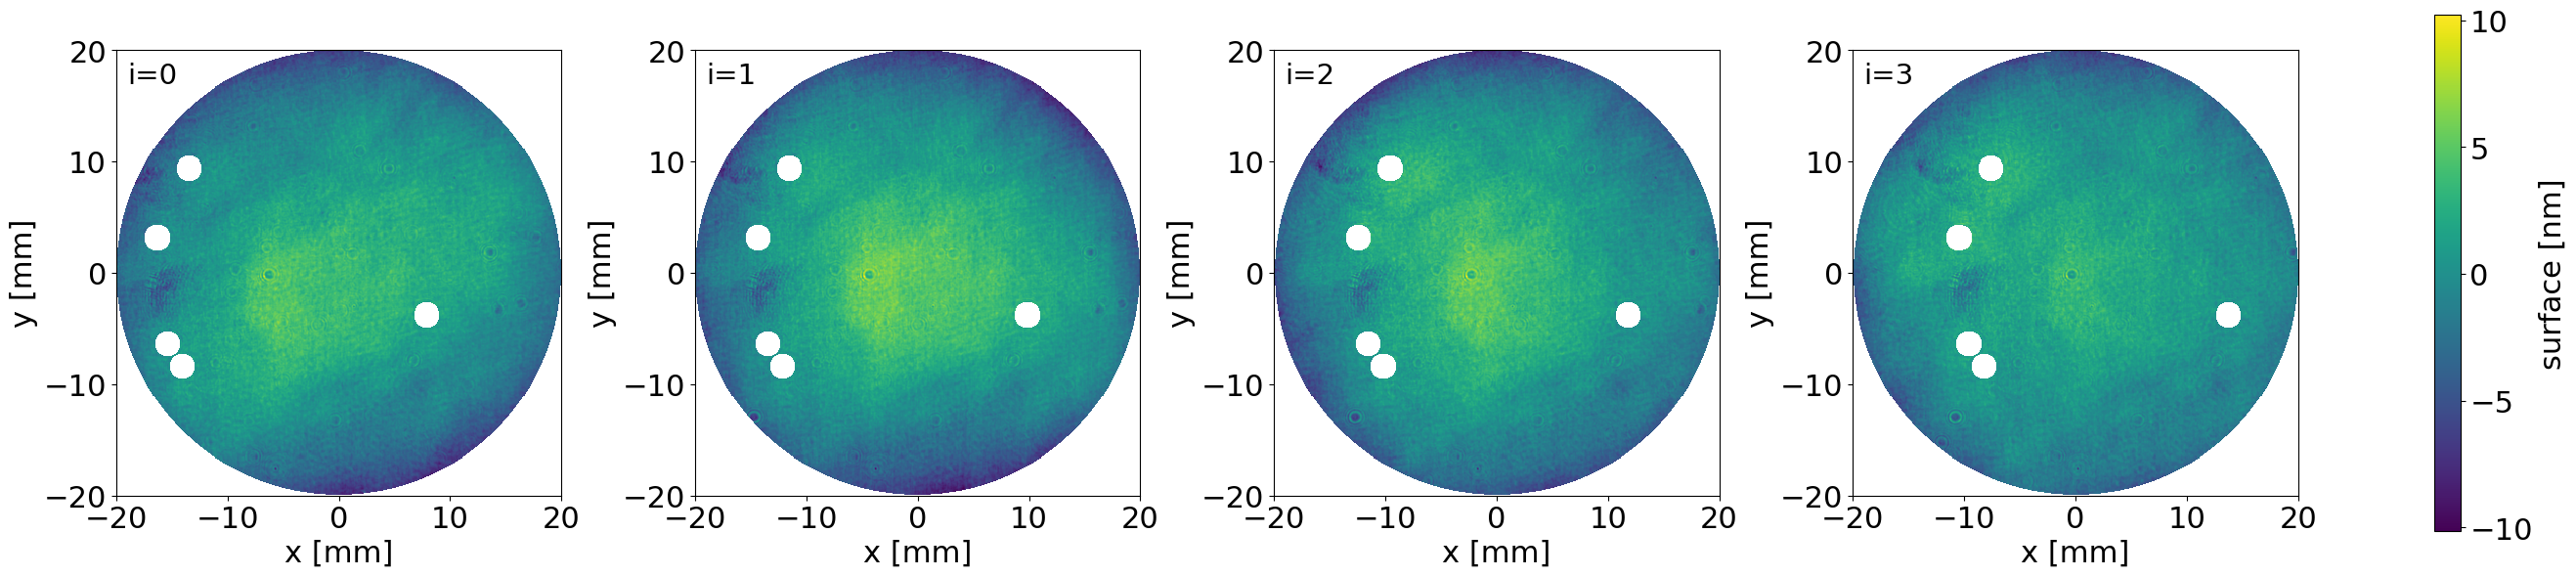

In [4]:
# generating the WFE data for the paper, do not delete please

# pick the data set
nf = 0
data_set = zm_cor_ptt[nf].to(u.nm)
vmin = np.amin(data_set.value)
vmax = np.amax(data_set.value)

# set the axis scaling
rks = dfx.calc_axis(data_set.shape[1], (latres*u.pix).to(u.mm))
rks_extent = [np.amin(rks).value, np.amax(rks).value, 
              np.amin(rks).value, np.amax(rks).value]

matplotlib.rcParams["font.size"]=22
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=100, figsize=(36,7))#, dpi=100)
fig.subplots_adjust(wspace=0.3)

n=0
for ax in axes.flat:
    sn_data = dfx.sn_map(data_set[n].value, dust_set[nf][n])
    im = ax.imshow(sn_data, origin='lower',
                   extent=rks_extent, vmin=vmin, vmax=vmax)
    ax.set_xticks([-20, -10, 0, 10, 20])
    ax.set_yticks([-20, -10, 0, 10, 20])
    ax.set_xlabel('x [{0}]'.format(str(rks.unit)))
    ax.set_ylabel('y [{0}]'.format(str(rks.unit)))
    step_name = 'i={0}'.format(n)
    ax.text(-19, 17, step_name, fontsize=21, color='black')
    n += 1
    
fig.colorbar(im, ax=axes.ravel().tolist()).set_label('surface [{0}]'.format(str(data_set.unit)))
plt.show()

In [5]:
def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data-np.mean(data)))

# full set
data_flats = zm_cor_ptt.to(u.nm)
rms_set = np.zeros((tot_fm, tot_step))
for i in range(0, tot_fm):
    for j in range(0, tot_step):
        rms_set[i][j] = rms(data_flats[i][j][dust_set[i][j]==1].value)
indiv_avg = np.mean(rms_set, axis=1)
(np.mean(indiv_avg), np.std(indiv_avg))


(3.0037126463142183, 1.3904565469627288)

In [9]:
# flat shown for paper
data_flats = zm_cor_ptt.to(u.nm)
rms_set = np.zeros((1, tot_step))
for i in range(0, 1):
    for j in range(0, tot_step):
        rms_set[i][j] = rms(data_flats[i][j][dust_set[i][j]==1].value)
indiv_avg = np.mean(rms_set)
(np.mean(rms_set), np.std(rms_set))

(2.491086323682134, 0.38273057526039883)